In [2]:
# main.py

import os
import torch

class Config:
    # --- Project Paths ---
    # In Kaggle, this would be /kaggle/input/your-dataset-name/
    DATA_DIR = "/kaggle/input/dataset/traffic_wala_dataset" 
    # In Kaggle, this would be /kaggle/working/
    OUTPUT_DIR = "/kaggle/working/"
    
    # --- Model & Training Hyperparameters ---
    # We have 1 class (vehicle), but DETR needs an extra "no object" class
    NUM_CLASSES = 1
    
    IMAGE_SIZE = 480  # A good size for DETR
    BATCH_SIZE = 4    # Adjust based on your GPU memory
    EPOCHS = 50       # Train for a reasonable duration
    
    # Optimizer & Scheduler
    LEARNING_RATE = 1e-4  # Standard for AdamW with Transformers
    LR_BACKBONE = 1e-5    # A smaller LR for the pretrained backbone
    WEIGHT_DECAY = 1e-4
    
    # --- DETR-specific Parameters ---
    HIDDEN_DIM = 256  # Dimension of the Transformer features
    NHEADS = 8        # Number of attention heads
    NUM_ENCODER_LAYERS = 6
    NUM_DECODER_LAYERS = 6
    NUM_QUERIES = 100 # Max number of objects to detect per image

# Ensure the output directory exists
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

# Set the device
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Configuration loaded. Running on device: {DEVICE}")

Configuration loaded. Running on device: cuda


In [3]:
# transforms.py

import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transform():
    """Defines the transformations for the training set."""
    return A.Compose([
        # Geometric augmentations
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        
        # Photometric augmentations
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.7),
        
        # Normalization and conversion to Tensor
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], 
    # This part is crucial for making augmentations work on bounding boxes
    bbox_params=A.BboxParams(
        format='yolo', # Input format is YOLO: [class_id, cx, cy, w, h]
        min_visibility=0.3,
        label_fields=['class_labels'] # Links 'class_labels' to the bboxes
    ))

def get_valid_transform():
    """Defines the transformations for the validation/testing set."""
    return A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], 
    bbox_params=A.BboxParams(
        format='yolo', 
        label_fields=['class_labels']
    ))

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# dataset.py

import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os

class VehicleDataset(Dataset):
    """
    Custom PyTorch Dataset for loading vehicle images and their YOLO-formatted labels.
    It returns data in a format compatible with the DETR model.
    """
    def __init__(self, image_dir, label_dir, transforms=None):
        super().__init__()
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        
        # Get all image file names from the image directory
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """Loads and returns one sample from the dataset at the given index."""
        # --- 1. Get file paths ---
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + '.txt')

        # --- 2. Load image and labels ---
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        bboxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    # YOLO format: class_id, x_center, y_center, width, height
                    parts = [float(p) for p in line.strip().split()]
                    bboxes.append(parts)
        
        bboxes = np.array(bboxes)
        
        # Resize image without augmentations first to match label coordinates
        h, w, _ = image.shape
        image = cv2.resize(image, (480, 480)) # Corresponds to Config.IMAGE_SIZE
        
        # --- 3. Apply augmentations ---
        if self.transforms:
            if len(bboxes) > 0:
                class_labels = bboxes[:, 0]
                bbox_coords = bboxes[:, 1:]
                
                transformed = self.transforms(image=image, bboxes=bbox_coords, class_labels=class_labels)
                image = transformed['image']
                
                if len(transformed['bboxes']) > 0:
                    bboxes = np.hstack((
                        np.array(transformed['class_labels']).reshape(-1, 1),
                        np.array(transformed['bboxes'])
                    ))
                else:
                    bboxes = np.array([])
            else:
                transformed = self.transforms(image=image, bboxes=[], class_labels=[])
                image = transformed['image']
                bboxes = np.array([])
        
        # --- 4. Prepare target dictionary for DETR ---
        target = {}
        if len(bboxes) > 0:
            boxes = torch.as_tensor(bboxes[:, 1:], dtype=torch.float32)
            # DETR expects box format [center_x, center_y, width, height]
            # YOLO format is already this, so no conversion is needed.
            target['boxes'] = boxes
            # Labels should be 0-indexed for our single class
            target['labels'] = torch.as_tensor(bboxes[:, 0], dtype=torch.long)
        else:
            # Handle cases with no objects
            target['boxes'] = torch.empty((0, 4), dtype=torch.float32)
            target['labels'] = torch.empty(0, dtype=torch.long)
            
        return image, target

In [5]:
# detr.py

import torch
from torch import nn
from torchvision.models import resnet50

class DETR(nn.Module):
    """
    This is the main DETR module. It consists of a CNN backbone, a transformer,
    and prediction heads.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # --- 1. The CNN Backbone ---
        # We use a pre-trained ResNet-50, but remove its final classification layer.
        self.backbone = resnet50(weights='DEFAULT')
        del self.backbone.fc
        
        # The backbone outputs features with 2048 channels. We need to project
        # this down to the transformer's dimension (hidden_dim).
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # --- 2. The Transformer ---
        # This is a standard PyTorch Transformer module.
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers
        )

        # --- 3. Prediction Heads ---
        # These are simple feed-forward networks (linear layers) to predict the
        # class and bounding box for each object query.
        
        # The class head predicts a score for each class, plus a "no object" class.
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        
        # The box head predicts 4 values (cx, cy, w, h) for the bounding box.
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # --- 4. Positional Encodings & Object Queries ---
        # These are crucial for the transformer to understand object positions.
        
        # These are learnable embeddings, one for each object query.
        # The number of queries is the maximum number of objects the model can detect.
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        
        # These are fixed positional encodings for the image features from the backbone.
        # We create them once and reuse them.
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # --- Backbone Pass ---
        # Propagate inputs through the backbone to get feature maps.
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        # Project the backbone's output to the transformer's dimension.
        h = self.conv(x)
        
        # --- Prepare for Transformer ---
        # Construct the positional encodings for the image features.
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)
        
        # The transformer expects inputs of shape (sequence_length, batch_size, hidden_dim).
        # We need to reshape our tensors accordingly.
        h = h.flatten(2).permute(2, 0, 1)
        pos = pos.to(h.device) # Ensure positional encodings are on the same device
        query_pos = self.query_pos.unsqueeze(1).repeat(1, inputs.shape[0], 1)
        
        # --- Transformer Pass ---
        # The transformer takes the image features, their positional encodings,
        # and the object queries as input.
        output = self.transformer(pos + h, query_pos).transpose(0, 1)
        
        # --- Prediction Heads Pass ---
        # The transformer's output is passed through the prediction heads.
        class_logits = self.linear_class(output)
        pred_boxes = self.linear_bbox(output).sigmoid() # Sigmoid ensures coords are in [0, 1]
        
        # The final output is a dictionary containing the predictions.
        return {'pred_logits': class_logits, 'pred_boxes': pred_boxes}

def create_model(num_classes):
    """A helper function to create the DETR model."""
    model = DETR(
        num_classes=num_classes,
        hidden_dim=256,
        nheads=8,
        num_encoder_layers=6,
        num_decoder_layers=6
    )
    return model

In [6]:
# main.py

import os
import torch

# ===================================================================
#                      CONFIGURATION CLASS
# ===================================================================
class Config:
    """A central place for all hyperparameters and settings."""
    # --- Project Paths ---
    # In Kaggle, this would be /kaggle/input/your-dataset-name/
    DATA_DIR = "path/to/your/dataset" 
    # In Kaggle, this would be /kaggle/working/
    OUTPUT_DIR = "outputs"
    
    # --- Model & Training Hyperparameters ---
    NUM_CLASSES = 1
    IMAGE_SIZE = 480
    BATCH_SIZE = 4
    EPOCHS = 200
    
    # Optimizer & Scheduler
    LEARNING_RATE = 1e-4
    LR_BACKBONE = 1e-5
    WEIGHT_DECAY = 1e-4
    
    # --- DETR-specific Parameters ---
    HIDDEN_DIM = 256
    NHEADS = 8
    NUM_ENCODER_LAYERS = 6
    NUM_DECODER_LAYERS = 6
    NUM_QUERIES = 100

# ===================================================================
#                        MAIN EXECUTION
# ===================================================================
def main():
    """The main function to run the setup and tests."""
    
    # --- 1. Create an instance of the Config class ---
    config = Config()
    
    # --- 2. Now you can safely access its attributes ---
    # Ensure the output directory exists
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)

    # Set the device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Configuration loaded. Running on device: {device}")

    # --- 3. Model Initialization Check ---
    print("\n--- Initializing Model ---")
    # Create the model using the function from detr.py
    # We pass NUM_CLASSES from our config object.
    model = create_model(num_classes=config.NUM_CLASSES)
    model = model.to(device)

    # Optional: Print the model architecture
    # print(model)

    # Optional: Test with a dummy input to check for runtime errors
    try:
        dummy_input = torch.randn(2, 3, config.IMAGE_SIZE, config.IMAGE_SIZE).to(device)
        outputs = model(dummy_input)
        print("\n--- Dummy Forward Pass Successful! ---")
        print("Output keys:", outputs.keys())
        print(f"Logits shape: {outputs['pred_logits'].shape}") # Should be [2, 100, 2]
        print(f"Boxes shape: {outputs['pred_boxes'].shape}")   # Should be [2, 100, 4]
    except Exception as e:
        print(f"\n--- Dummy Forward Pass Failed! ---")
        print(e)

# --- 4. This standard Python construct ensures main() is called when the script is run ---
if __name__ == '__main__':
    main()

Configuration loaded. Running on device: cuda

--- Initializing Model ---


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- Dummy Forward Pass Successful! ---
Output keys: dict_keys(['pred_logits', 'pred_boxes'])
Logits shape: torch.Size([2, 100, 2])
Boxes shape: torch.Size([2, 100, 4])


In [7]:
# loss.py

import torch
from torch import nn
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from torchvision.ops.boxes import box_iou, generalized_box_iou

def box_cxcywh_to_xyxy(x):
    """Converts boxes from [center_x, center_y, width, height] to [x1, y1, x2, y2]."""
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

class HungarianMatcher(nn.Module):
    """
    This class computes an assignment between the ground-truth and the predictions of the model.
    The cost of matching a prediction to a ground-truth is a combination of:
        - The classification cost (the probability of the correct class)
        - The regression cost (a mix of L1 and GIoU loss between boxes)
    """
    def __init__(self, cost_class: float = 1, cost_bbox: float = 5, cost_giou: float = 2):
        super().__init__()
        # These are weights for the different components of the cost matrix.
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        # The cost must be normalized.
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """
        Performs the matching.
        
        Args:
            outputs: A dictionary from the model containing 'pred_logits' and 'pred_boxes'.
            targets: A list of dictionaries, where each dict contains 'labels' and 'boxes'.
            
        Returns:
            A list of (prediction_idx, target_idx) pairs for each image in the batch.
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten the batch dimension for easier processing
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also, concatenate all ground-truth info
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # --- 1. Compute the classification cost ---
        # The cost is the negative probability of the target class.
        cost_class = -out_prob[:, tgt_ids]

        # --- 2. Compute the L1 regression cost ---
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
        
        # --- 3. Compute the GIoU cost ---
        # Convert boxes to xyxy format for GIoU calculation
        out_bbox_xyxy = box_cxcywh_to_xyxy(out_bbox)
        tgt_bbox_xyxy = box_cxcywh_to_xyxy(tgt_bbox)
        cost_giou = -generalized_box_iou(out_bbox_xyxy, tgt_bbox_xyxy)

        # --- Final cost matrix ---
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        # Use linear_sum_assignment (Hungarian algorithm) to find the best assignment
        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        
        # Return the matched indices as a list of tuples
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]


class SetCriterion(nn.Module):
    """
    This class computes the final loss for DETR.
    The process happens in two steps:
    1. Compute the hungarian assignment between ground truth and predictions.
    2. Supervise each pair of matched ground-truth / prediction.
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef # Relative weight of the "no object" class
        
        # The CrossEntropyLoss weight should penalize the "no object" class less.
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes):
        """Classification loss (NLL)"""
        pred_logits = outputs['pred_logits']

        # Get the indices of the matched predictions and targets
        idx = self._get_src_permutation_idx(indices)
        
        # Create a target tensor with the correct class for matched queries
        # and "no object" class for the rest.
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(pred_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=pred_logits.device)
        target_classes[idx] = target_classes_o

        # Compute the cross-entropy loss
        loss_ce = F.cross_entropy(pred_logits.transpose(1, 2), target_classes, self.empty_weight)
        return {'loss_ce': loss_ce}

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Bbox regression loss (a sum of L1 and GIoU)."""
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        # L1 loss
        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')
        
        # GIoU loss
        src_boxes_xyxy = box_cxcywh_to_xyxy(src_boxes)
        target_boxes_xyxy = box_cxcywh_to_xyxy(target_boxes)
        loss_giou = 1 - torch.diag(generalized_box_iou(src_boxes_xyxy, target_boxes_xyxy))
        
        return {
            'loss_bbox': loss_bbox.sum() / num_boxes,
            'loss_giou': loss_giou.sum() / num_boxes
        }
        
    def _get_src_permutation_idx(self, indices):
        # Permute the indices to be able to select from flattened batch
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def forward(self, outputs, targets):
        """
        This is the main forward method.
        
        Returns:
            A dictionary of losses.
        """
        # Step 1: Compute the Hungarian matching
        indices = self.matcher(outputs, targets)

        # Compute the number of boxes for normalization
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        
        # Step 2: Compute all the requested losses
        losses = {}
        losses.update(self.loss_labels(outputs, targets, indices, num_boxes))
        losses.update(self.loss_boxes(outputs, targets, indices, num_boxes))
        
        return losses

In [8]:
# main.py
import os
import torch


# ... (Config class is the same) ...

def main():
    config = Config()
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Configuration loaded. Running on device: {device}")

    # --- Model Initialization ---
    model = create_model(num_classes=config.NUM_CLASSES).to(device)
    
    # --- NEW: Loss Function Initialization ---
    matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
    weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
    criterion = SetCriterion(
        num_classes=config.NUM_CLASSES, 
        matcher=matcher, 
        weight_dict=weight_dict, 
        eos_coef=0.1 # This penalizes "no object" predictions less.
    ).to(device)
    
    print("\n--- Model and Criterion Initialized ---")
    
    # --- Test with a dummy forward and backward pass ---
    try:
        # Create dummy inputs and targets
        dummy_input = torch.randn(2, 3, config.IMAGE_SIZE, config.IMAGE_SIZE).to(device)
        dummy_targets = [
            {'boxes': torch.rand(3, 4).to(device), 'labels': torch.randint(0, config.NUM_CLASSES, (3,)).to(device)},
            {'boxes': torch.rand(2, 4).to(device), 'labels': torch.randint(0, config.NUM_CLASSES, (2,)).to(device)}
        ]
        
        # Forward pass
        outputs = model(dummy_input)
        
        # Loss calculation
        loss_dict = criterion(outputs, dummy_targets)
        
        # Weighted sum of losses for backpropagation
        total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        print("\n--- Dummy Forward & Loss Calculation Successful! ---")
        print("Calculated Losses:", {k: v.item() for k, v in loss_dict.items()})
        print(f"Total Weighted Loss: {total_loss.item():.4f}")
        
        # Quick backward pass check
        total_loss.backward()
        print("\n--- Dummy Backward Pass Successful! ---")
        
    except Exception as e:
        print("\n--- Dummy Pass Failed! ---")
        print(e)


if __name__ == '__main__':
    main()

Configuration loaded. Running on device: cuda

--- Model and Criterion Initialized ---

--- Dummy Forward & Loss Calculation Successful! ---
Calculated Losses: {'loss_ce': 0.6691805720329285, 'loss_bbox': 0.7582368850708008, 'loss_giou': 0.8516845703125}
Total Weighted Loss: 6.1637

--- Dummy Backward Pass Successful! ---


In [9]:
# engine.py

import torch
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# The function signature now accepts the lr_scheduler to step it per iteration
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, lr_scheduler):
    """
    Trains the model for one epoch with gradient clipping and per-iteration scheduling.
    """
    model.train()
    criterion.train()
    
    loop = tqdm(data_loader, desc=f"Epoch {epoch+1} [Training]")
    total_loss = 0.0
    
    for images, targets in loop:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(torch.stack(images))
        
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        
        # --- THIS IS THE NEW, CRITICAL LINE ---
        # Clip the gradients to a maximum norm of 0.1.
        # This prevents the gradients from becoming too large and destabilizing training.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        
        optimizer.step()
        
        # --- STEP THE SCHEDULER PER ITERATION ---
        # The new scheduler works on a per-batch basis, not per-epoch.
        lr_scheduler.step()
        
        total_loss += losses.item()
        loop.set_postfix(loss=losses.item())
        
    return total_loss / len(data_loader)


# The 'validate' function remains unchanged.
@torch.no_grad()
def validate(model, data_loader, device):
    # ... (code for validation is the same as before) ...
    model.eval()
    map_metric = MeanAveragePrecision(box_format="cxcywh", class_metrics=True).to(device)
    loop = tqdm(data_loader, desc="[Validation]")
    for images, targets in loop:
        images = [img.to(device) for img in images]
        targets_gpu = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(torch.stack(images))
        scores = outputs['pred_logits'].softmax(-1)[:, :, :-1]
        preds = []
        for i in range(len(targets)):
            pred = {
                'boxes': outputs['pred_boxes'][i],
                'scores': scores[i].max(-1).values,
                'labels': scores[i].argmax(-1),
            }
            preds.append(pred)
        map_metric.update(preds, targets_gpu)
    metrics = map_metric.compute()
    return {k: v.item() for k,v in metrics.items()}

In [13]:
# main.py

import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import math # Import the math module for the scheduler


# ===================================================================
#                      CONFIGURATION
# ===================================================================
class Config:
    # Set your paths here
    TRAIN_IMG_DIR = '/kaggle/input/dataset/traffic_wala_dataset/train/images'
    TRAIN_LBL_DIR = '/kaggle/input/dataset/traffic_wala_dataset/train/labels'
    VALID_IMG_DIR = '/kaggle/input/dataset/traffic_wala_dataset/valid/images'
    VALID_LBL_DIR = '/kaggle/input/dataset/traffic_wala_dataset/valid/labels'
    OUTPUT_DIR = '/kaggle/working/outputs'
    
    # --- HYPERPARAMETER CHANGES FOR STABILITY ---
    NUM_CLASSES = 1
    IMAGE_SIZE = 480
    BATCH_SIZE = 4
    EPOCHS = 200 # Increased significantly to allow for convergence
    
    # Lower learning rates
    LEARNING_RATE = 2e-5 # Was 1e-4, a more conservative value
    LR_BACKBONE = 2e-6   # Was 1e-5
    WEIGHT_DECAY = 1e-4
    
    # DETR-specific Parameters
    NUM_QUERIES = 100

def collate_fn(batch):
    return tuple(zip(*batch))

# ===================================================================
#                        MAIN EXECUTION
# ===================================================================
def main():
    config = Config()
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Running on device: {device}")

    # --- DataLoaders ---
    train_dataset = VehicleDataset(image_dir=config.TRAIN_IMG_DIR, label_dir=config.TRAIN_LBL_DIR, transforms=get_train_transform())
    valid_dataset = VehicleDataset(image_dir=config.VALID_IMG_DIR, label_dir=config.VALID_LBL_DIR, transforms=get_valid_transform())
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)
    
    # --- Model and Criterion ---
    model = create_model(num_classes=config.NUM_CLASSES).to(device)
    matcher = HungarianMatcher()
    weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
    criterion = SetCriterion(num_classes=config.NUM_CLASSES, matcher=matcher, weight_dict=weight_dict, eos_coef=0.1).to(device)
    
    # --- Optimizer and NEW Learning Rate Scheduler ---
    param_dicts = [
        {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
        {"params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad], "lr": config.LR_BACKBONE},
    ]
    optimizer = optim.AdamW(param_dicts, lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
    
    # Linear warmup followed by cosine decay scheduler
    # This is a common and effective strategy for training Transformers.
    warmup_factor = 1.0 / 1000
    warmup_iters = min(1000, len(train_loader) - 1)

    def lr_lambda(current_step):
        # Linear warmup phase
        if current_step < warmup_iters:
            return float(current_step) / float(max(1.0, warmup_iters))
        # Cosine decay phase
        progress = float(current_step - warmup_iters) / float(max(1, config.EPOCHS * len(train_loader) - warmup_iters))
        return 0.5 * (1.0 + math.cos(math.pi * progress))

    lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # --- The Training Loop ---
    print("\n--- Starting Training with Improved Stability ---")
    best_map = 0.0

    for epoch in range(config.EPOCHS):
        # The scheduler is now passed to the training function to be stepped per-iteration
        train_loss = train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, lr_scheduler)
        
        # We no longer step the scheduler per epoch
        
        metrics = validate(model, valid_loader, device)
        map_val = metrics.get('map', 0.0)
        
        print(f"\n----- Epoch {epoch+1}/{config.EPOCHS} Summary -----")
        print(f"  - Training Loss: {train_loss:.4f}")
        print(f"  - Validation mAP @ .50:.95: {map_val:.4f}")
        print(f"  - Validation mAP @ .50:     {metrics.get('map_50', 0.0):.4f}")

        if map_val > best_map:
            print(f"\nNew best model found! mAP improved from {best_map:.4f} to {map_val:.4f}")
            best_map = map_val
            torch.save(model.state_dict(), os.path.join(config.OUTPUT_DIR, 'detr_best_model.pth'))
            print(f"Model saved to {config.OUTPUT_DIR}/detr_best_model.pth")

    print("\n--- Training Complete ---")
    print(f"Final best validation mAP: {best_map:.4f}")

if __name__ == '__main__':
    main()

Running on device: cuda

--- Starting Training with Improved Stability ---


[Validation]: 100%|██████████| 23/23 [00:02<00:00, 10.86it/s]



----- Epoch 1/200 Summary -----
  - Training Loss: 4.9204
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0002

New best model found! mAP improved from 0.0000 to 0.0000
Model saved to /kaggle/working/outputs/detr_best_model.pth


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 13.00it/s]



----- Epoch 2/200 Summary -----
  - Training Loss: 4.1837
  - Validation mAP @ .50:.95: 0.0002
  - Validation mAP @ .50:     0.0010

New best model found! mAP improved from 0.0000 to 0.0002
Model saved to /kaggle/working/outputs/detr_best_model.pth


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.80it/s]



----- Epoch 3/200 Summary -----
  - Training Loss: 3.7144
  - Validation mAP @ .50:.95: 0.0001
  - Validation mAP @ .50:     0.0004


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.62it/s]



----- Epoch 4/200 Summary -----
  - Training Loss: 3.3877
  - Validation mAP @ .50:.95: 0.0002
  - Validation mAP @ .50:     0.0011

New best model found! mAP improved from 0.0002 to 0.0002
Model saved to /kaggle/working/outputs/detr_best_model.pth


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.53it/s]



----- Epoch 5/200 Summary -----
  - Training Loss: 3.1710
  - Validation mAP @ .50:.95: 0.0009
  - Validation mAP @ .50:     0.0022

New best model found! mAP improved from 0.0002 to 0.0009
Model saved to /kaggle/working/outputs/detr_best_model.pth


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.19it/s]



----- Epoch 6/200 Summary -----
  - Training Loss: 3.2256
  - Validation mAP @ .50:.95: 0.0002
  - Validation mAP @ .50:     0.0005


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.48it/s]



----- Epoch 7/200 Summary -----
  - Training Loss: 3.2170
  - Validation mAP @ .50:.95: 0.0023
  - Validation mAP @ .50:     0.0100

New best model found! mAP improved from 0.0009 to 0.0023
Model saved to /kaggle/working/outputs/detr_best_model.pth


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.45it/s]



----- Epoch 8/200 Summary -----
  - Training Loss: 3.0997
  - Validation mAP @ .50:.95: 0.0002
  - Validation mAP @ .50:     0.0008


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.47it/s]



----- Epoch 9/200 Summary -----
  - Training Loss: 3.1061
  - Validation mAP @ .50:.95: 0.0001
  - Validation mAP @ .50:     0.0006


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]



----- Epoch 10/200 Summary -----
  - Training Loss: 3.0771
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 11/200 Summary -----
  - Training Loss: 3.0812
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]



----- Epoch 12/200 Summary -----
  - Training Loss: 2.9918
  - Validation mAP @ .50:.95: 0.0033
  - Validation mAP @ .50:     0.0100

New best model found! mAP improved from 0.0023 to 0.0033
Model saved to /kaggle/working/outputs/detr_best_model.pth


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]



----- Epoch 13/200 Summary -----
  - Training Loss: 3.1286
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 14/200 Summary -----
  - Training Loss: 2.9477
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 15/200 Summary -----
  - Training Loss: 3.0094
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.09it/s]



----- Epoch 16/200 Summary -----
  - Training Loss: 2.9436
  - Validation mAP @ .50:.95: 0.0022
  - Validation mAP @ .50:     0.0050


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 17/200 Summary -----
  - Training Loss: 2.8931
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 18/200 Summary -----
  - Training Loss: 2.9352
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 19/200 Summary -----
  - Training Loss: 2.9734
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 20/200 Summary -----
  - Training Loss: 2.8800
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 21/200 Summary -----
  - Training Loss: 2.9017
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]



----- Epoch 22/200 Summary -----
  - Training Loss: 2.8884
  - Validation mAP @ .50:.95: 0.0004
  - Validation mAP @ .50:     0.0025


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 23/200 Summary -----
  - Training Loss: 2.9385
  - Validation mAP @ .50:.95: 0.0002
  - Validation mAP @ .50:     0.0009


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]



----- Epoch 24/200 Summary -----
  - Training Loss: 2.8827
  - Validation mAP @ .50:.95: 0.0024
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 25/200 Summary -----
  - Training Loss: 2.8515
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 26/200 Summary -----
  - Training Loss: 2.8472
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.44it/s]



----- Epoch 27/200 Summary -----
  - Training Loss: 2.8351
  - Validation mAP @ .50:.95: 0.0061
  - Validation mAP @ .50:     0.0099

New best model found! mAP improved from 0.0033 to 0.0061
Model saved to /kaggle/working/outputs/detr_best_model.pth


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 28/200 Summary -----
  - Training Loss: 2.8927
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 29/200 Summary -----
  - Training Loss: 2.8885
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.34it/s]



----- Epoch 30/200 Summary -----
  - Training Loss: 2.8346
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.40it/s]



----- Epoch 31/200 Summary -----
  - Training Loss: 2.8311
  - Validation mAP @ .50:.95: 0.0042
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 32/200 Summary -----
  - Training Loss: 2.8091
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.20it/s]



----- Epoch 33/200 Summary -----
  - Training Loss: 2.8163
  - Validation mAP @ .50:.95: 0.0007
  - Validation mAP @ .50:     0.0050


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 34/200 Summary -----
  - Training Loss: 2.8248
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 35/200 Summary -----
  - Training Loss: 2.7771
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.03it/s]



----- Epoch 36/200 Summary -----
  - Training Loss: 2.8060
  - Validation mAP @ .50:.95: 0.0002
  - Validation mAP @ .50:     0.0010


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]



----- Epoch 37/200 Summary -----
  - Training Loss: 2.8143
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.20it/s]



----- Epoch 38/200 Summary -----
  - Training Loss: 2.8150
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 39/200 Summary -----
  - Training Loss: 2.8273
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 40/200 Summary -----
  - Training Loss: 2.7574
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.11it/s]



----- Epoch 41/200 Summary -----
  - Training Loss: 2.7611
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]



----- Epoch 42/200 Summary -----
  - Training Loss: 2.7369
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 43/200 Summary -----
  - Training Loss: 2.7919
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 44/200 Summary -----
  - Training Loss: 2.7735
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]



----- Epoch 45/200 Summary -----
  - Training Loss: 2.7420
  - Validation mAP @ .50:.95: 0.0007
  - Validation mAP @ .50:     0.0050


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.12it/s]



----- Epoch 46/200 Summary -----
  - Training Loss: 2.7361
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 47/200 Summary -----
  - Training Loss: 2.7374
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]



----- Epoch 48/200 Summary -----
  - Training Loss: 2.7735
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 49/200 Summary -----
  - Training Loss: 2.7006
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 50/200 Summary -----
  - Training Loss: 2.7649
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.21it/s]



----- Epoch 51/200 Summary -----
  - Training Loss: 2.7487
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 52/200 Summary -----
  - Training Loss: 2.7315
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 53/200 Summary -----
  - Training Loss: 2.7683
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 54/200 Summary -----
  - Training Loss: 2.7443
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 55/200 Summary -----
  - Training Loss: 2.7385
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.04it/s]



----- Epoch 56/200 Summary -----
  - Training Loss: 2.7001
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.45it/s]



----- Epoch 57/200 Summary -----
  - Training Loss: 2.7213
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]



----- Epoch 58/200 Summary -----
  - Training Loss: 2.7332
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]



----- Epoch 59/200 Summary -----
  - Training Loss: 2.7220
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 60/200 Summary -----
  - Training Loss: 2.6811
  - Validation mAP @ .50:.95: 0.0001
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 61/200 Summary -----
  - Training Loss: 2.6845
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.34it/s]



----- Epoch 62/200 Summary -----
  - Training Loss: 2.6803
  - Validation mAP @ .50:.95: 0.0022
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.34it/s]



----- Epoch 63/200 Summary -----
  - Training Loss: 2.6805
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]



----- Epoch 64/200 Summary -----
  - Training Loss: 2.7115
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]



----- Epoch 65/200 Summary -----
  - Training Loss: 2.7016
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.14it/s]



----- Epoch 66/200 Summary -----
  - Training Loss: 2.6825
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 67/200 Summary -----
  - Training Loss: 2.6804
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.42it/s]



----- Epoch 68/200 Summary -----
  - Training Loss: 2.6794
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 69/200 Summary -----
  - Training Loss: 2.6772
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.43it/s]



----- Epoch 70/200 Summary -----
  - Training Loss: 2.7184
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]



----- Epoch 71/200 Summary -----
  - Training Loss: 2.6741
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]



----- Epoch 72/200 Summary -----
  - Training Loss: 2.6405
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 73/200 Summary -----
  - Training Loss: 2.7089
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.48it/s]



----- Epoch 74/200 Summary -----
  - Training Loss: 2.6734
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 75/200 Summary -----
  - Training Loss: 2.6630
  - Validation mAP @ .50:.95: 0.0027
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 11.98it/s]



----- Epoch 76/200 Summary -----
  - Training Loss: 2.6908
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.40it/s]



----- Epoch 77/200 Summary -----
  - Training Loss: 2.6487
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]



----- Epoch 78/200 Summary -----
  - Training Loss: 2.6530
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]



----- Epoch 79/200 Summary -----
  - Training Loss: 2.6807
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 80/200 Summary -----
  - Training Loss: 2.6671
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.47it/s]



----- Epoch 81/200 Summary -----
  - Training Loss: 2.6745
  - Validation mAP @ .50:.95: 0.0055
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.34it/s]



----- Epoch 82/200 Summary -----
  - Training Loss: 2.6825
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]



----- Epoch 83/200 Summary -----
  - Training Loss: 2.6836
  - Validation mAP @ .50:.95: 0.0030
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]



----- Epoch 84/200 Summary -----
  - Training Loss: 2.6215
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 85/200 Summary -----
  - Training Loss: 2.6322
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 86/200 Summary -----
  - Training Loss: 2.6508
  - Validation mAP @ .50:.95: 0.0041
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]



----- Epoch 87/200 Summary -----
  - Training Loss: 2.6568
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 88/200 Summary -----
  - Training Loss: 2.6731
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 11.75it/s]



----- Epoch 89/200 Summary -----
  - Training Loss: 2.6780
  - Validation mAP @ .50:.95: 0.0001
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]



----- Epoch 90/200 Summary -----
  - Training Loss: 2.6482
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.19it/s]



----- Epoch 91/200 Summary -----
  - Training Loss: 2.6208
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 92/200 Summary -----
  - Training Loss: 2.6021
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 93/200 Summary -----
  - Training Loss: 2.6179
  - Validation mAP @ .50:.95: 0.0059
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 94/200 Summary -----
  - Training Loss: 2.6292
  - Validation mAP @ .50:.95: 0.0030
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.33it/s]



----- Epoch 95/200 Summary -----
  - Training Loss: 2.6332
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 96/200 Summary -----
  - Training Loss: 2.6505
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 97/200 Summary -----
  - Training Loss: 2.6055
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.29it/s]



----- Epoch 98/200 Summary -----
  - Training Loss: 2.6278
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]



----- Epoch 99/200 Summary -----
  - Training Loss: 2.6424
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.33it/s]



----- Epoch 100/200 Summary -----
  - Training Loss: 2.5996
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]



----- Epoch 101/200 Summary -----
  - Training Loss: 2.6256
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 102/200 Summary -----
  - Training Loss: 2.6304
  - Validation mAP @ .50:.95: 0.0001
  - Validation mAP @ .50:     0.0009


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 103/200 Summary -----
  - Training Loss: 2.6016
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]



----- Epoch 104/200 Summary -----
  - Training Loss: 2.6105
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 105/200 Summary -----
  - Training Loss: 2.6560
  - Validation mAP @ .50:.95: 0.0030
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 106/200 Summary -----
  - Training Loss: 2.6124
  - Validation mAP @ .50:.95: 0.0030
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.33it/s]



----- Epoch 107/200 Summary -----
  - Training Loss: 2.6080
  - Validation mAP @ .50:.95: 0.0023
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 108/200 Summary -----
  - Training Loss: 2.5837
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 11.95it/s]



----- Epoch 109/200 Summary -----
  - Training Loss: 2.5812
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.40it/s]



----- Epoch 110/200 Summary -----
  - Training Loss: 2.6259
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 111/200 Summary -----
  - Training Loss: 2.5881
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 112/200 Summary -----
  - Training Loss: 2.6123
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.43it/s]



----- Epoch 113/200 Summary -----
  - Training Loss: 2.6080
  - Validation mAP @ .50:.95: 0.0054
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 114/200 Summary -----
  - Training Loss: 2.6170
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 115/200 Summary -----
  - Training Loss: 2.6213
  - Validation mAP @ .50:.95: 0.0021
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 116/200 Summary -----
  - Training Loss: 2.5768
  - Validation mAP @ .50:.95: 0.0003
  - Validation mAP @ .50:     0.0033


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.43it/s]



----- Epoch 117/200 Summary -----
  - Training Loss: 2.6009
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]



----- Epoch 118/200 Summary -----
  - Training Loss: 2.6151
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.24it/s]



----- Epoch 119/200 Summary -----
  - Training Loss: 2.5831
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 120/200 Summary -----
  - Training Loss: 2.6126
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.24it/s]



----- Epoch 121/200 Summary -----
  - Training Loss: 2.5964
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.34it/s]



----- Epoch 122/200 Summary -----
  - Training Loss: 2.6033
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.34it/s]



----- Epoch 123/200 Summary -----
  - Training Loss: 2.6215
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]



----- Epoch 124/200 Summary -----
  - Training Loss: 2.5823
  - Validation mAP @ .50:.95: 0.0072
  - Validation mAP @ .50:     0.0099

New best model found! mAP improved from 0.0061 to 0.0072
Model saved to /kaggle/working/outputs/detr_best_model.pth


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.19it/s]



----- Epoch 125/200 Summary -----
  - Training Loss: 2.5605
  - Validation mAP @ .50:.95: 0.0020
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]



----- Epoch 126/200 Summary -----
  - Training Loss: 2.5695
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.29it/s]



----- Epoch 127/200 Summary -----
  - Training Loss: 2.5917
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.33it/s]



----- Epoch 128/200 Summary -----
  - Training Loss: 2.5755
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.26it/s]



----- Epoch 129/200 Summary -----
  - Training Loss: 2.5980
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.54it/s]



----- Epoch 130/200 Summary -----
  - Training Loss: 2.5797
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]



----- Epoch 131/200 Summary -----
  - Training Loss: 2.5807
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.40it/s]



----- Epoch 132/200 Summary -----
  - Training Loss: 2.5791
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]



----- Epoch 133/200 Summary -----
  - Training Loss: 2.5452
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.26it/s]



----- Epoch 134/200 Summary -----
  - Training Loss: 2.5527
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 135/200 Summary -----
  - Training Loss: 2.5873
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]



----- Epoch 136/200 Summary -----
  - Training Loss: 2.5795
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 137/200 Summary -----
  - Training Loss: 2.5458
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.34it/s]



----- Epoch 138/200 Summary -----
  - Training Loss: 2.5561
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.06it/s]



----- Epoch 139/200 Summary -----
  - Training Loss: 2.5699
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.17it/s]



----- Epoch 140/200 Summary -----
  - Training Loss: 2.5622
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.50it/s]



----- Epoch 141/200 Summary -----
  - Training Loss: 2.5676
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 142/200 Summary -----
  - Training Loss: 2.5674
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.47it/s]



----- Epoch 143/200 Summary -----
  - Training Loss: 2.5681
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 144/200 Summary -----
  - Training Loss: 2.5406
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 145/200 Summary -----
  - Training Loss: 2.5466
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]



----- Epoch 146/200 Summary -----
  - Training Loss: 2.5468
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 147/200 Summary -----
  - Training Loss: 2.5510
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.24it/s]



----- Epoch 148/200 Summary -----
  - Training Loss: 2.5369
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.20it/s]



----- Epoch 149/200 Summary -----
  - Training Loss: 2.5492
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]



----- Epoch 150/200 Summary -----
  - Training Loss: 2.5673
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.29it/s]



----- Epoch 151/200 Summary -----
  - Training Loss: 2.5547
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.40it/s]



----- Epoch 152/200 Summary -----
  - Training Loss: 2.5492
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 153/200 Summary -----
  - Training Loss: 2.5709
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 154/200 Summary -----
  - Training Loss: 2.5459
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.49it/s]



----- Epoch 155/200 Summary -----
  - Training Loss: 2.5459
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 156/200 Summary -----
  - Training Loss: 2.5515
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 157/200 Summary -----
  - Training Loss: 2.5332
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 158/200 Summary -----
  - Training Loss: 2.5398
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 159/200 Summary -----
  - Training Loss: 2.5438
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]



----- Epoch 160/200 Summary -----
  - Training Loss: 2.5471
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]



----- Epoch 161/200 Summary -----
  - Training Loss: 2.5443
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]



----- Epoch 162/200 Summary -----
  - Training Loss: 2.5268
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 163/200 Summary -----
  - Training Loss: 2.5257
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.40it/s]



----- Epoch 164/200 Summary -----
  - Training Loss: 2.5504
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.25it/s]



----- Epoch 165/200 Summary -----
  - Training Loss: 2.5297
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.21it/s]



----- Epoch 166/200 Summary -----
  - Training Loss: 2.5515
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.47it/s]



----- Epoch 167/200 Summary -----
  - Training Loss: 2.5459
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]



----- Epoch 168/200 Summary -----
  - Training Loss: 2.5324
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]



----- Epoch 169/200 Summary -----
  - Training Loss: 2.5404
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 170/200 Summary -----
  - Training Loss: 2.5319
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]



----- Epoch 171/200 Summary -----
  - Training Loss: 2.5269
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]



----- Epoch 172/200 Summary -----
  - Training Loss: 2.5482
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



----- Epoch 173/200 Summary -----
  - Training Loss: 2.5241
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.42it/s]



----- Epoch 174/200 Summary -----
  - Training Loss: 2.5172
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]



----- Epoch 175/200 Summary -----
  - Training Loss: 2.5352
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.10it/s]



----- Epoch 176/200 Summary -----
  - Training Loss: 2.5336
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]



----- Epoch 177/200 Summary -----
  - Training Loss: 2.5221
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 178/200 Summary -----
  - Training Loss: 2.5301
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0001


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.35it/s]



----- Epoch 179/200 Summary -----
  - Training Loss: 2.5404
  - Validation mAP @ .50:.95: 0.0010
  - Validation mAP @ .50:     0.0099


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]



----- Epoch 180/200 Summary -----
  - Training Loss: 2.5167
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]



----- Epoch 181/200 Summary -----
  - Training Loss: 2.5222
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.20it/s]



----- Epoch 182/200 Summary -----
  - Training Loss: 2.5119
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 183/200 Summary -----
  - Training Loss: 2.5028
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]



----- Epoch 184/200 Summary -----
  - Training Loss: 2.5261
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]



----- Epoch 185/200 Summary -----
  - Training Loss: 2.5176
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]



----- Epoch 186/200 Summary -----
  - Training Loss: 2.5095
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.23it/s]



----- Epoch 187/200 Summary -----
  - Training Loss: 2.5273
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 188/200 Summary -----
  - Training Loss: 2.5175
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.43it/s]



----- Epoch 189/200 Summary -----
  - Training Loss: 2.5249
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.45it/s]



----- Epoch 190/200 Summary -----
  - Training Loss: 2.5384
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]



----- Epoch 191/200 Summary -----
  - Training Loss: 2.5255
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]



----- Epoch 192/200 Summary -----
  - Training Loss: 2.5279
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]



----- Epoch 193/200 Summary -----
  - Training Loss: 2.5129
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.24it/s]



----- Epoch 194/200 Summary -----
  - Training Loss: 2.5397
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.45it/s]



----- Epoch 195/200 Summary -----
  - Training Loss: 2.5383
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.36it/s]



----- Epoch 196/200 Summary -----
  - Training Loss: 2.5214
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.55it/s]



----- Epoch 197/200 Summary -----
  - Training Loss: 2.5328
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]



----- Epoch 198/200 Summary -----
  - Training Loss: 2.5408
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.02it/s]



----- Epoch 199/200 Summary -----
  - Training Loss: 2.5237
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000


[Validation]: 100%|██████████| 23/23 [00:01<00:00, 12.42it/s]



----- Epoch 200/200 Summary -----
  - Training Loss: 2.5325
  - Validation mAP @ .50:.95: 0.0000
  - Validation mAP @ .50:     0.0000

--- Training Complete ---
Final best validation mAP: 0.0072


Loading model from /kaggle/working/outputs/detr_best_model.pth...
Model loaded successfully.

Displaying 5 images with predictions (confidence > 0.6)...
Green boxes = Ground Truth | Blue boxes = Predictions


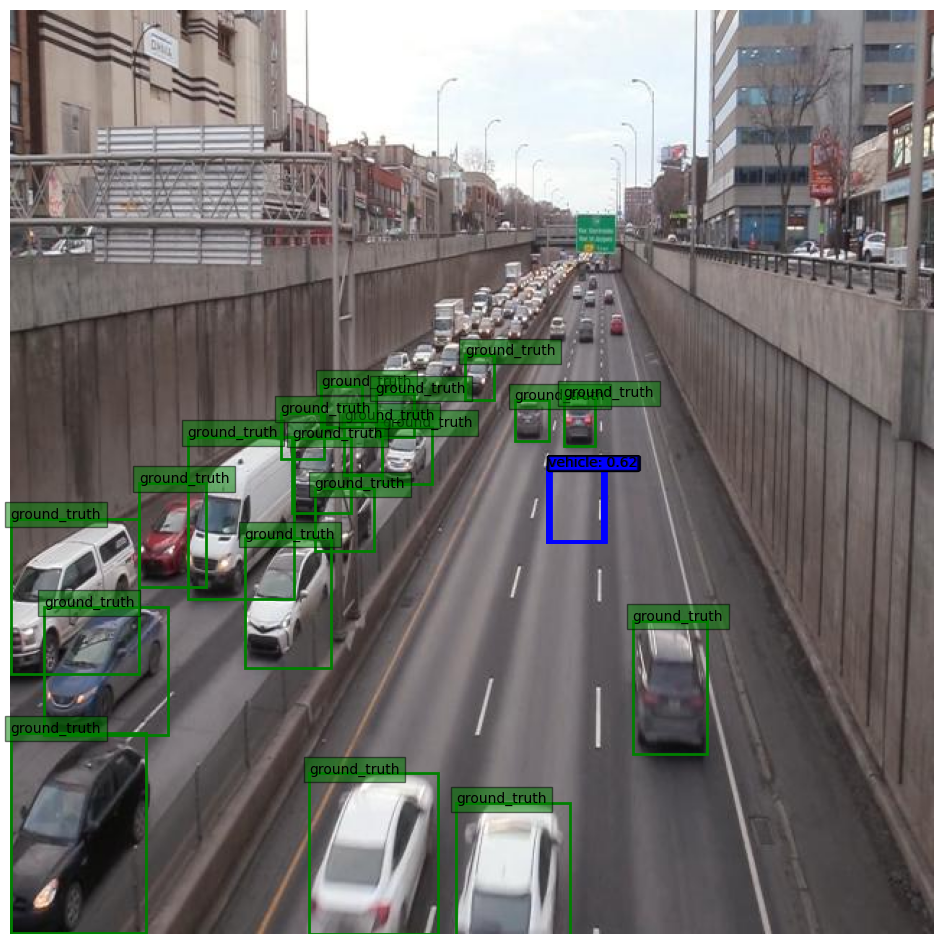

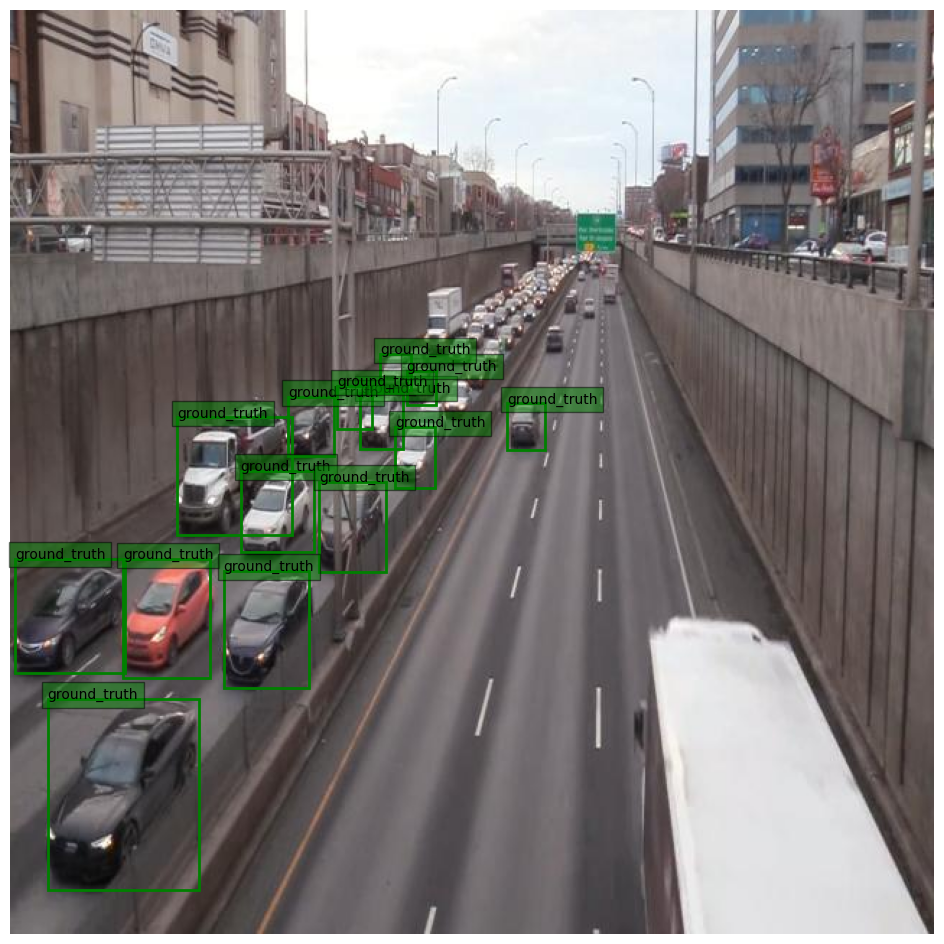

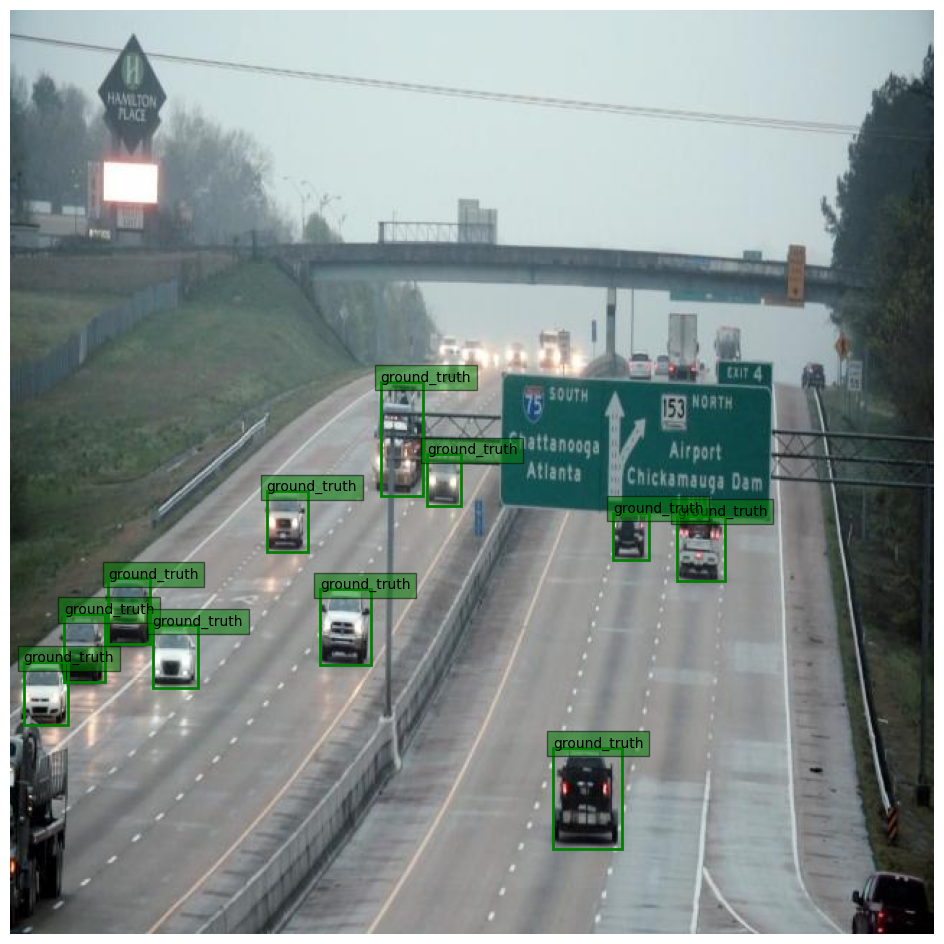

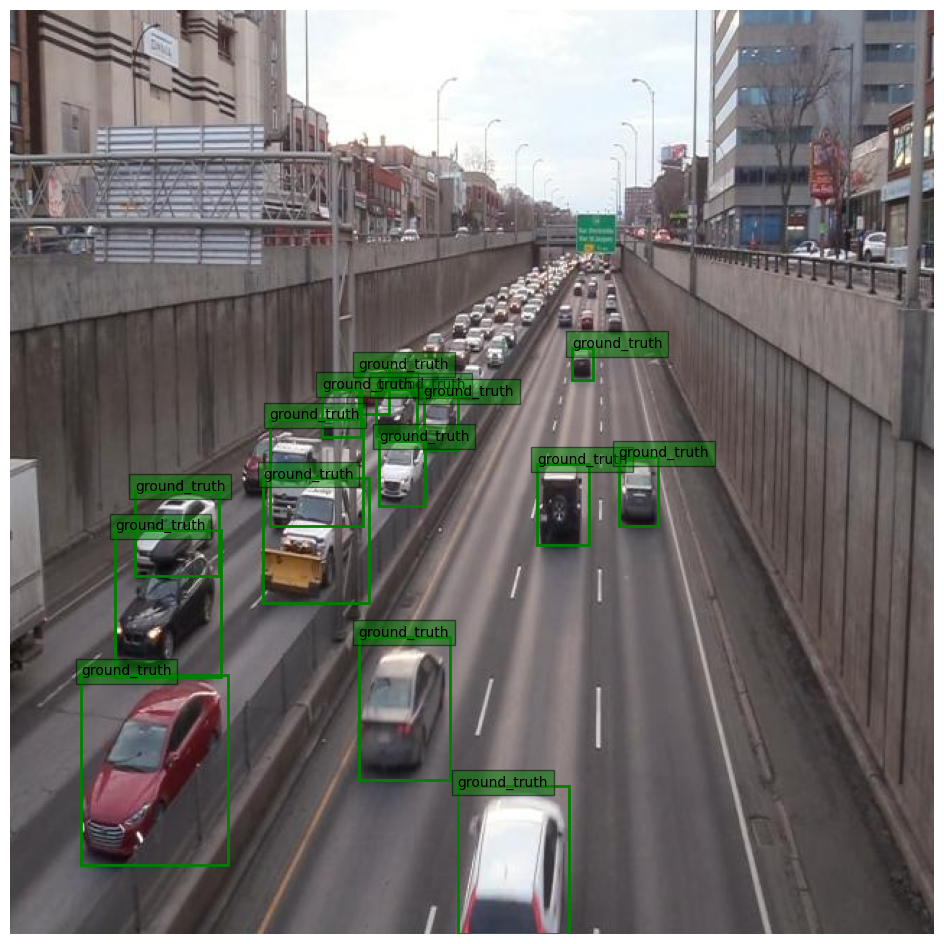

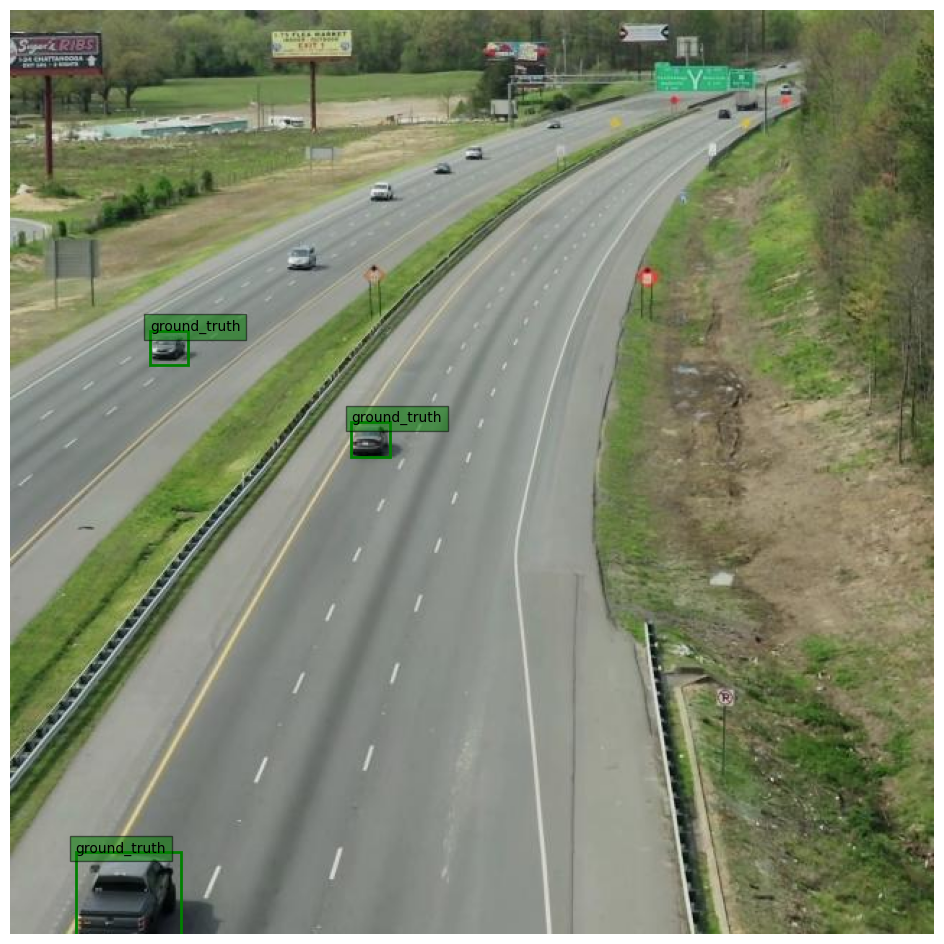

In [15]:
# visualize.py

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
# ===================================================================
#                      VISUALIZATION CONFIGURATION
# ===================================================================
class VizConfig:
    # --- Paths ---
    # Update these paths to match your setup
    VALID_IMG_DIR = '/kaggle/input/dataset/traffic_wala_dataset/valid/images'
    VALID_LBL_DIR = '/kaggle/input/dataset/traffic_wala_dataset/valid/labels'
    MODEL_PATH = '/kaggle/working/outputs/detr_best_model.pth'
    
    # --- Parameters (MUST MATCH THE TRAINED MODEL) ---
    NUM_CLASSES = 1
    IMAGE_SIZE = 480
    
    # --- Visualization Settings ---
    NUM_IMAGES_TO_SHOW = 5
    CONFIDENCE_THRESHOLD = 0.6 # Only show predictions with confidence > 60%

# ===================================================================
#                        HELPER FUNCTIONS
# ===================================================================

# Function to convert box from [cx, cy, w, h] to [x1, y1, x2, y2]
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# Function to rescale boxes from [0, 1] to image size
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_one_image(image_path, label_path, model, transform, device, threshold):
    """Loads one image, runs inference, and plots the results."""
    
    # --- 1. Load and Prepare Image and Ground Truth ---
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = (image.shape[1], image.shape[0]) # (width, height)
    
    # Load ground truth labels
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = [float(p) for p in line.strip().split()]
                gt_boxes.append(parts[1:]) # Skip class_id
    
    # Apply transformations to the image for model input
    image_tensor = transform(image=image, bboxes=[], class_labels=[])['image']
    
    # --- 2. Run Inference ---
    model.eval()
    with torch.no_grad():
        # Add a batch dimension and send to device
        input_tensor = image_tensor.unsqueeze(0).to(device)
        outputs = model(input_tensor)

    # --- 3. Process Outputs ---
    # Move outputs to CPU
    pred_logits = outputs['pred_logits'][0].cpu()
    pred_boxes = outputs['pred_boxes'][0].cpu()
    
    # Apply softmax to get probabilities and filter by confidence
    probas = pred_logits.softmax(-1)
    scores, labels = probas[:, :-1].max(-1) # Ignore the "no object" class
    
    keep = scores > threshold
    
    # Rescale predicted boxes to original image size
    boxes_scaled = rescale_bboxes(pred_boxes[keep], original_size)
    
    # --- 4. Draw and Display ---
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    ax.imshow(image)
    
    # Draw Ground Truth Boxes (in Green)
    for box in gt_boxes:
        cx, cy, w, h = box
        x1 = (cx - w / 2) * original_size[0]
        y1 = (cy - h / 2) * original_size[1]
        w_px = w * original_size[0]
        h_px = h * original_size[1]
        ax.add_patch(plt.Rectangle((x1, y1), w_px, h_px, fill=False, color='green', linewidth=2))
        ax.text(x1, y1, 'ground_truth', bbox={'facecolor':'green', 'alpha':0.5})

    # Draw Predicted Boxes (in Blue)
    for score, box in zip(scores[keep], boxes_scaled):
        x1, y1, x2, y2 = box
        w_px = x2 - x1
        h_px = y2 - y1
        ax.add_patch(plt.Rectangle((x1, y1), w_px, h_px, fill=False, color='blue', linewidth=2))
        label = f'vehicle: {score:.2f}'
        ax.text(x1, y1, label, bbox={'facecolor':'blue', 'alpha':0.5, 'pad': 0})
        
    plt.axis('off')
    plt.show()

# ===================================================================
#                        MAIN VISUALIZATION SCRIPT
# ===================================================================
def visualize():
    config = VizConfig()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    # --- 1. Load Model ---
    print(f"Loading model from {config.MODEL_PATH}...")
    # Create a model with the same architecture as during training
    model = create_model(num_classes=config.NUM_CLASSES).to(device)
    # Load the saved weights
    model.load_state_dict(torch.load(config.MODEL_PATH, map_location=device))
    print("Model loaded successfully.")
    
    # --- 2. Get random images from validation set ---
    all_image_files = sorted(os.listdir(config.VALID_IMG_DIR))
    # Select a random sample of images to visualize
    image_files_to_show = random.sample(all_image_files, k=min(config.NUM_IMAGES_TO_SHOW, len(all_image_files)))
    
    # Get the validation transform (without augmentations)
    transform = get_valid_transform()
    
    print(f"\nDisplaying {len(image_files_to_show)} images with predictions (confidence > {config.CONFIDENCE_THRESHOLD})...")
    print("Green boxes = Ground Truth | Blue boxes = Predictions")
    
    # --- 3. Loop through images and plot results ---
    for image_file in image_files_to_show:
        image_path = os.path.join(config.VALID_IMG_DIR, image_file)
        label_path = os.path.join(config.VALID_LBL_DIR, os.path.splitext(image_file)[0] + '.txt')
        
        plot_one_image(image_path, label_path, model, transform, device, config.CONFIDENCE_THRESHOLD)

if __name__ == '__main__':
    # Make sure to update the paths in VizConfig before running!
    visualize()